## Análisis de Clustering
En esta clase nos vamos a concentrar en realizar y comparar diferentes técnicas de clustering. Vamos a estar usando un dataset sobre vinos!

Algo interesante de este dataset es que cuenta con la información sobre a qué variedad pertenece cada uno de los vinos, por lo que vamos a poder tomar medidas de Validación externa sobre nuestros clusters

In [ ]:
#kneed es una libreria que nos va a ayudar a aplicar el "método del codo". Pero deberemos instalarla primero!
!pip install kneed

In [ ]:
#Librerias generales
import numpy as np
import pandas as pd
from random import sample
from numpy.random import uniform
%matplotlib inline

#sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score

#Visualizacion
import matplotlib.pyplot as plt
import seaborn as sns

#Otros
import scipy.cluster.hierarchy as shc
from yellowbrick.cluster import silhouette_visualizer
from kneed import KneeLocator

In [ ]:
# # Link con el Drive
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
#Importamos los datos(lo estoy haciendo desde mi Drive, ustedes pueden hacerlo de la misma forma o cargar el dataset desde sus PCs)
wine = pd.read_csv('wine_data.csv')

### Preprocesamiento

In [ ]:
#¿Qué pinta tiene?
wine.head()

,class,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [ ]:
#Tenemos 178 vinos (!) y un total de 13 atributos (sin contar la columna class que es la variedad del vino)
wine.shape

(178, 14)

In [ ]:
#Todos los atributos son numéricos, pero vean que hay una gran diferencia en cuanto a la distribución de los distintos atributos.
wine.describe()

,class,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,1.938202,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.775035,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,1.000000,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,1.000000,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,2.000000,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,3.000000,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,3.000000,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


In [ ]:
#¿Cuantos vinos tenemos de cada variedad?
wine['class'].value_counts()

2    71
1    59
3    48
Name: class, dtype: int64

In [ ]:
#Para todos los métodos de clustering que vamos a hacer no vamos a usar la info de la clase (metodos no supervisados)
wine_class = wine['class']
wine_f     = wine.drop(['class'], axis = 1, inplace = False)

Estandarizacion de los datos
Como dijimos en la clase, es muy importante llevar a todas las variables a la misma escala de valores!

In [ ]:
#Guardo el nombre de las columnas
cols = wine_f.columns

#Estandarizacion
scaler = StandardScaler()
scaled = scaler.fit_transform(wine_f)
wine_f = pd.DataFrame(scaled, columns = cols)
wine_f.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009
1,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242
2,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148
3,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574
4,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874


In [ ]:
#¿Funcionó?
wine_f.describe()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
count,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,178.000000,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02
mean,-8.382808e-16,-1.197544e-16,-8.370333e-16,-3.991813e-17,-3.991813e-17,0.000000,-3.991813e-16,3.592632e-16,-1.197544e-16,2.494883e-17,1.995907e-16,3.193450e-16,-1.596725e-16
std,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00,1.002821e+00
min,-2.434235e+00,-1.432983e+00,-3.679162e+00,-2.671018e+00,-2.088255e+00,-2.107246,-1.695971e+00,-1.868234e+00,-2.069034e+00,-1.634288e+00,-2.094732e+00,-1.895054e+00,-1.493188e+00
25%,-7.882448e-01,-6.587486e-01,-5.721225e-01,-6.891372e-01,-8.244151e-01,-0.885468,-8.275393e-01,-7.401412e-01,-5.972835e-01,-7.951025e-01,-7.675624e-01,-9.522483e-01,-7.846378e-01
50%,6.099988e-02,-4.231120e-01,-2.382132e-02,1.518295e-03,-1.222817e-01,0.095960,1.061497e-01,-1.760948e-01,-6.289785e-02,-1.592246e-01,3.312687e-02,2.377348e-01,-2.337204e-01
75%,8.361286e-01,6.697929e-01,6.981085e-01,6.020883e-01,5.096384e-01,0.808997,8.490851e-01,6.095413e-01,6.291754e-01,4.939560e-01,7.131644e-01,7.885875e-01,7.582494e-01
max,2.259772e+00,3.109192e+00,3.156325e+00,3.154511e+00,4.371372e+00,2.539515,3.062832e+00,2.402403e+00,3.485073e+00,3.435432e+00,3.301694e+00,1.960915e+00,2.971473e+00


Nuestros datos, ¿tienen tendencia a agruparse en grupos?
Para contestar esta pregunta, vamos a calcular el **estadístico de Hopkins** y vamos a "hacer a mano" usando código encontrado [aqui](https://github.com/prathmachowksey/Hopkins-Statistic-Clustering-Tendency/tree/master)

In [ ]:
# function to compute hopkins's statistic for the dataframe X
def hopkins_statistic(X):

    X=X.values  #convert dataframe to a numpy array
    sample_size = int(X.shape[0]*0.05) #0.05 (5%) based on paper by Lawson and Jures


    #a uniform random sample in the original data space
    X_uniform_random_sample = uniform(X.min(axis=0), X.max(axis=0) ,(sample_size , X.shape[1]))



    #a random sample of size sample_size from the original data X
    random_indices=sample(range(0, X.shape[0], 1), sample_size)
    X_sample = X[random_indices]


    #initialise unsupervised learner for implementing neighbor searches
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs=neigh.fit(X)

    #u_distances = nearest neighbour distances from uniform random sample
    u_distances , u_indices = nbrs.kneighbors(X_uniform_random_sample , n_neighbors=2)
    u_distances = u_distances[: , 0] #distance to the first (nearest) neighbour

    #w_distances = nearest neighbour distances from a sample of points from original data X
    w_distances , w_indices = nbrs.kneighbors(X_sample , n_neighbors=2)
    #distance to the second nearest neighbour (as the first neighbour will be the point itself, with distance = 0)
    w_distances = w_distances[: , 1]



    u_sum = np.sum(u_distances)
    w_sum = np.sum(w_distances)

    #compute and return hopkins' statistic
    H = u_sum/ (u_sum + w_sum)
    return H



In [ ]:
#¿Qué significa este valor?
H=hopkins_statistic(wine_f)
print(H)

0.6846095270528288


In [ ]:
#Cómo el valor de este estadístico depende de una comparación con una muestra aleatoria, lo vamos a calcular varias veces y promediar los distintos valores.
#De esta forma obtenemos un valor más consistente
l = []
for i in range(20):
    H=hopkins_statistic(wine_f)
    l.append(H)
#Valor del estadístico Hopkins promedio
np.mean(l)

0.7201434582235252

Visualización de los datos
Nuestros datos tienen 13 atributos, por lo que es imposible graficarlos todos juntos. Por esta razón vamos a realizar una reducción de dimensionalidad llamada **PCA (Análisis de componentes principales)**. En esta clase sólo lo vamos a utilizar con fines visuales, en las próximas clases nos vamos a concentrar más en profundidad en este tema.

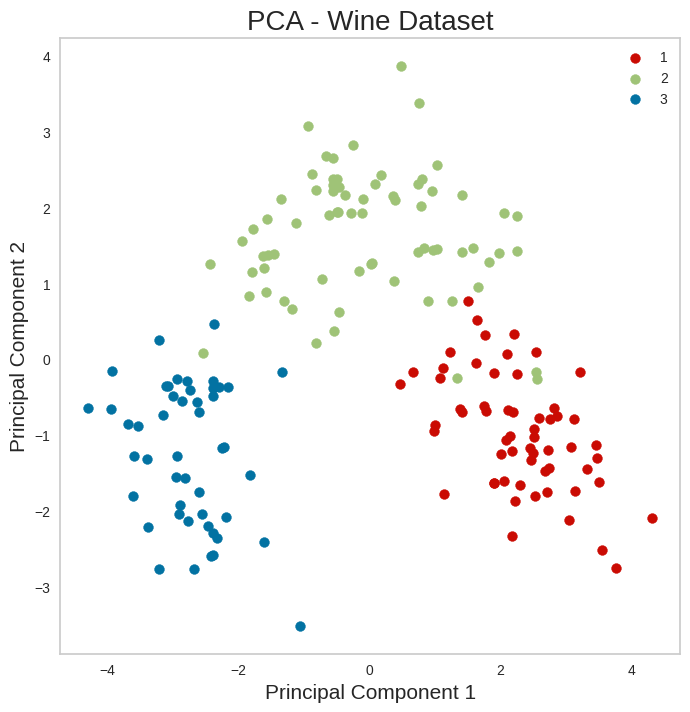

In [ ]:
#Realizamos el PCA
pca = PCA(n_components=2) #Vamos a representar nuestros datos en 2 dimensiones
principalComponents = pca.fit_transform(wine_f)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, wine_class], axis = 1)


#Graficamos la distribución de nuestros puntos en este nuevo espacio
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA - Wine Dataset', fontsize = 20)
targets = [1, 2, 3]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['class'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

### Clustering Jerarquico

Vamos a utilizar [scipy.cluster.hierarchy](https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html) para graficar algunos dendrogramas y elegir la forma en la que vamos a calcular la similaridad entre clusters.

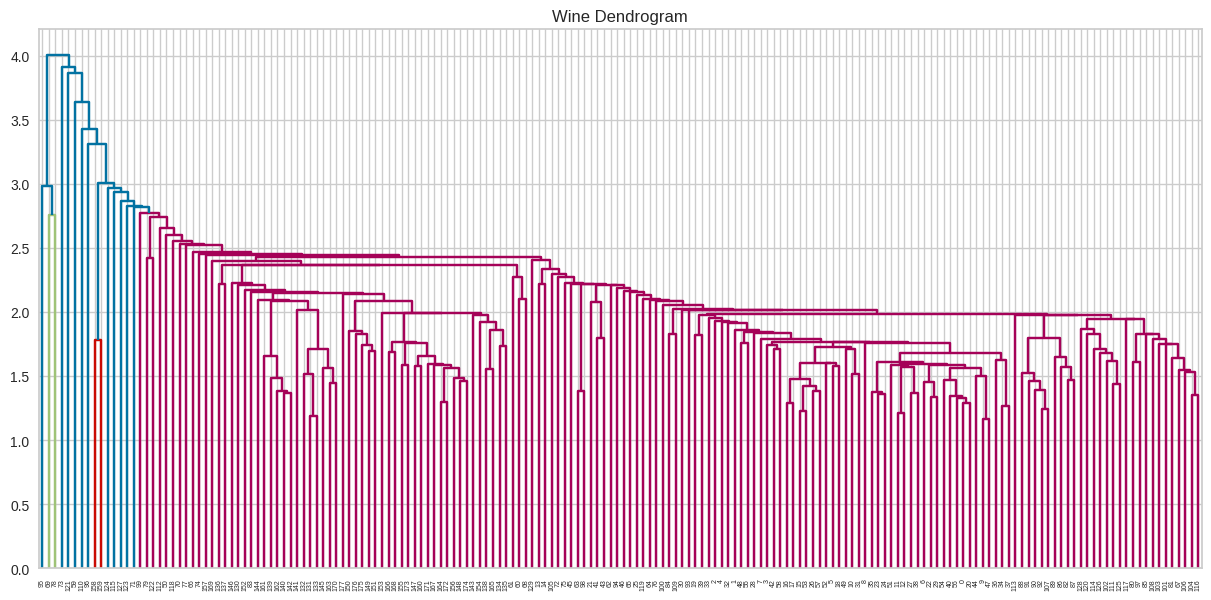

In [ ]:
#Single linkage
plt.figure(figsize=(15, 7))
plt.title("Wine Dendrogram")

clusters = shc.linkage(wine_f,
            method='single',
            metric="euclidean")
shc.dendrogram(Z=clusters)
plt.show()

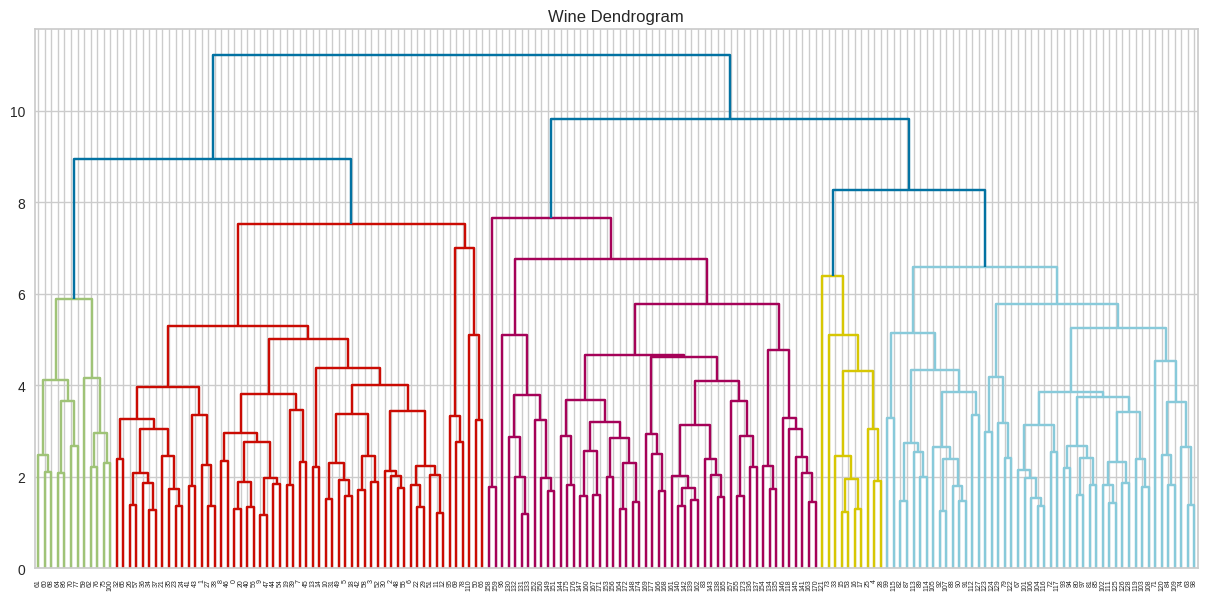

In [ ]:
#Complete linkage
plt.figure(figsize=(15, 7))
plt.title("Wine Dendrogram")

clusters = shc.linkage(wine_f,
            method='complete',
            metric="euclidean")
shc.dendrogram(Z=clusters)
plt.show()

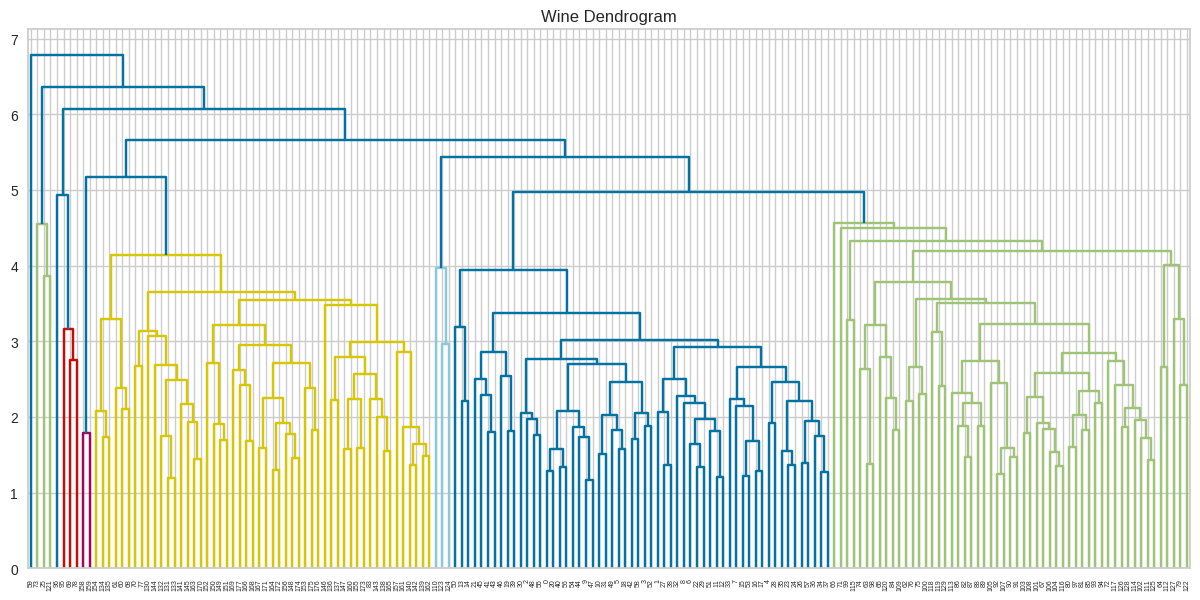

In [ ]:
#Average linkage
plt.figure(figsize=(15, 7))
plt.title("Wine Dendrogram")

clusters = shc.linkage(wine_f,
            method='average',
            metric="euclidean")
shc.dendrogram(Z=clusters)
plt.show()

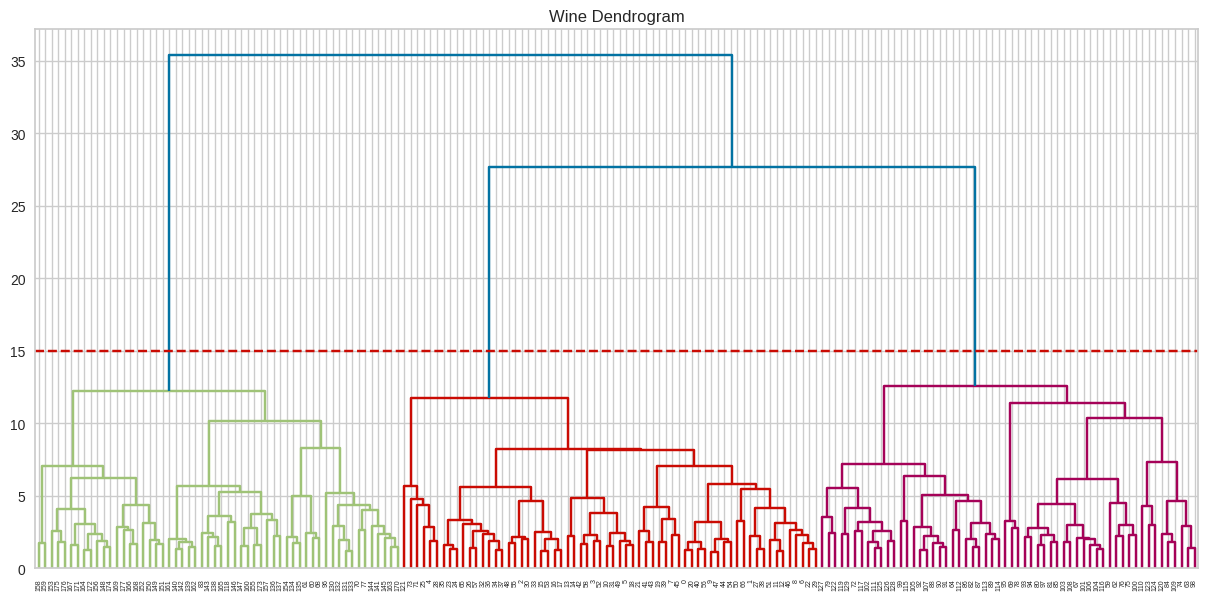

In [ ]:
#Ward linkage (este no llegamos a verlo en clase, pero es muy utilizado!)
plt.figure(figsize=(15, 7))
plt.title("Wine Dendrogram")

clusters = shc.linkage(wine_f,
            method='ward',
            metric="euclidean")
shc.dendrogram(Z=clusters)
plt.axhline(y = 15, color = 'r', linestyle = '--')
plt.show()

Decisión tomada! ¿Con cual nos quedamos? Con el método de Ward!
¿Por qué? Porque obtenemos agrupamientos con una buena distancia inter-clusters (se unen bastante arriba en el dendrograma).

**NOTA:** También coincide con lo que sabemos: hay tres grupos en nuestro dataset, pero eso no es lo más importante en este momento.

Utilizaremos [AgglomerativeClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html) de sklearn para realizar el clustering.

In [ ]:
#Fijense que ya le estamos diciendo que forme tres grupos, decisión que viene de ver el dendrograma!
clustering_model = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
clustering_model.fit(wine_f)

#¿Cómo podemos ver la asignación de las observaciones a los clusters?
clustering_model.labels_

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 1, 0, 0, 0, 2,
       2, 0, 1, 0, 1, 2, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [ ]:
#Vamos a ir guardando los agrupamientos que formemos con cada uno de los métodos en la misma tabla para compararlos al final
finalDf['hclust'] = clustering_model.labels_

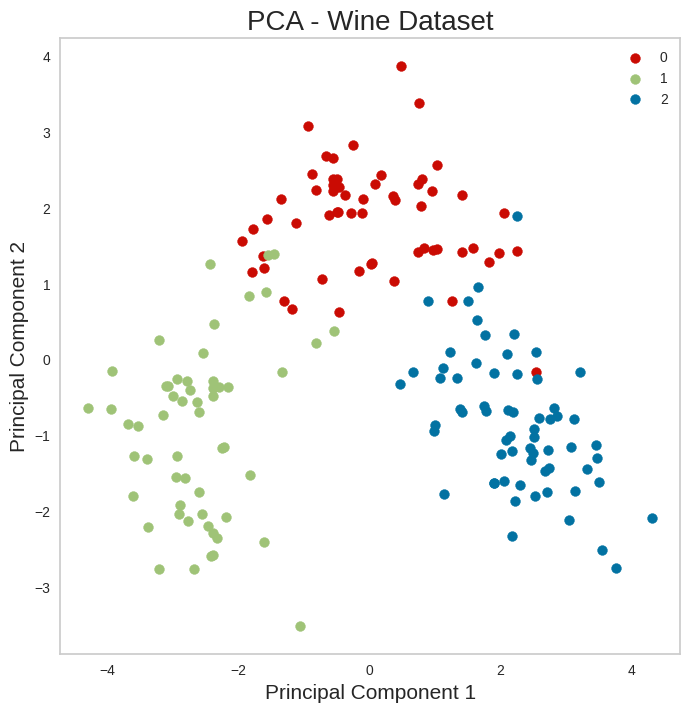

In [ ]:
#Veamos cómo quedan agrupados los puntos en nuestro espacio de PCA
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA - Wine Dataset', fontsize = 20)
targets = [0, 1, 2]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['hclust'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

### K-Means
Utilizaremos [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) de sklearn.
Lo primero que tendremos que hacer es definir el k óptimo para nuestros datos. Para eso vamos a probar distintos valores de k y elegiremos el mejor en base al "método del codo" utilizando la librería [kneed](https://pypi.org/project/kneed/)

In [ ]:
#Como kmeans tiene una inicialización aleatoria (se acuerdan?) sklearn nos permite realizar varias inicializaciones para poder obtener un resultado más robusto cambiando el parámtro n_init
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# SSE: Sum of Square Error
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(wine_f)
    sse.append(kmeans.inertia_)

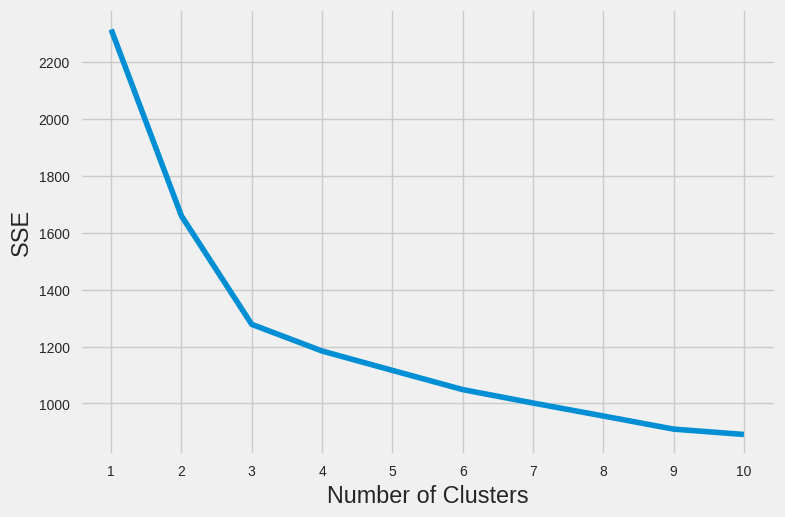

In [ ]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [ ]:
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
)

kl.elbow

3

¡Oh casualidad! El codo nos está diciendo que elijamos k=3, vamos a hacerle caso...

In [ ]:
kmeans = KMeans(
    init="random",
    n_clusters=3,
    n_init=10,
    max_iter=300,
    random_state=42
)

In [ ]:
kmeans.fit(wine_f)

KMeans(init='random', n_clusters=3, n_init=10, random_state=42)

In [ ]:
#¿Donde estan los centroides de los clusters que generó?
kmeans.cluster_centers_

array([[-0.92607185, -0.39404154, -0.49451676,  0.17060184, -0.49171185,
        -0.07598265,  0.02081257, -0.03353357,  0.0582655 , -0.90191402,
         0.46180361,  0.27076419, -0.75384618],
       [ 0.83523208, -0.30380968,  0.36470604, -0.61019129,  0.5775868 ,
         0.88523736,  0.97781956, -0.56208965,  0.58028658,  0.17106348,
         0.47398365,  0.77924711,  1.12518529],
       [ 0.16490746,  0.87154706,  0.18689833,  0.52436746, -0.07547277,
        -0.97933029, -1.21524764,  0.72606354, -0.77970639,  0.94153874,
        -1.16478865, -1.29241163, -0.40708796]])

In [ ]:
#Y la asignación de las observaciones a cada cluster...
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2], dtype=int32)

In [ ]:
#Lo sumamos a la tabla...
finalDf['kmeans'] = kmeans.labels_

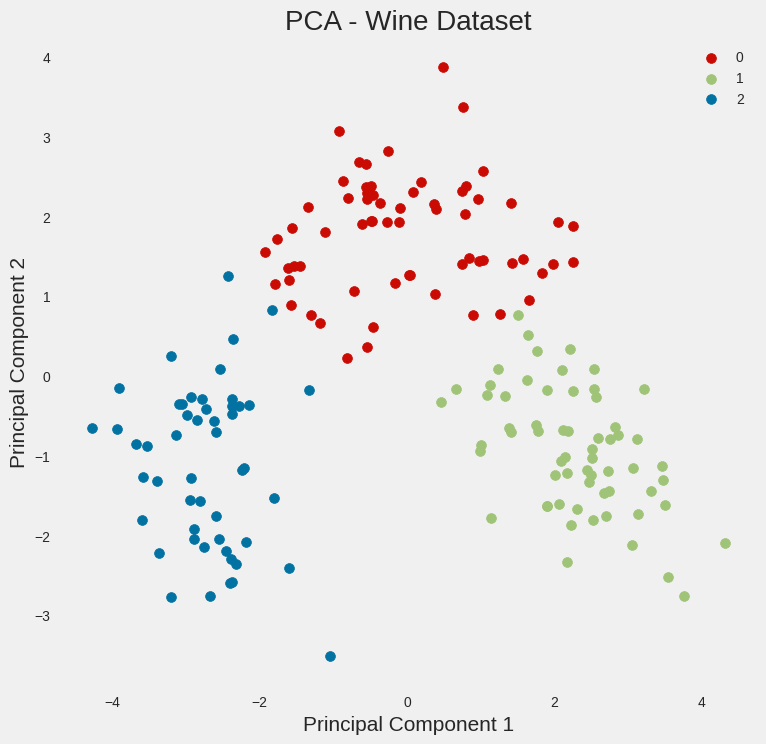

In [ ]:
#Cómo se verán nuestros datos con esta nueva ropa?
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA - Wine Dataset', fontsize = 20)
targets = [0, 1, 2]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['kmeans'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

### DBSCAN

Utilizaremos una vez más [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html).

DBScan tiene dos parámetros muy importantes: minPts y Eps(radio). El minPts depende de la densidad de punto que tenemos en nuestro dataset y es dificil determinar un valor óptimo. Sin embargo, para determinar el radio podemos calcular la distancia que hay entre cada cada punto y su vecino más cercano (el punto que tiene más cerca). De esta manera vamos a poder tener una idea de qué valor le podemos dar a Eps.



Text(0, 0.5, 'Distancia')

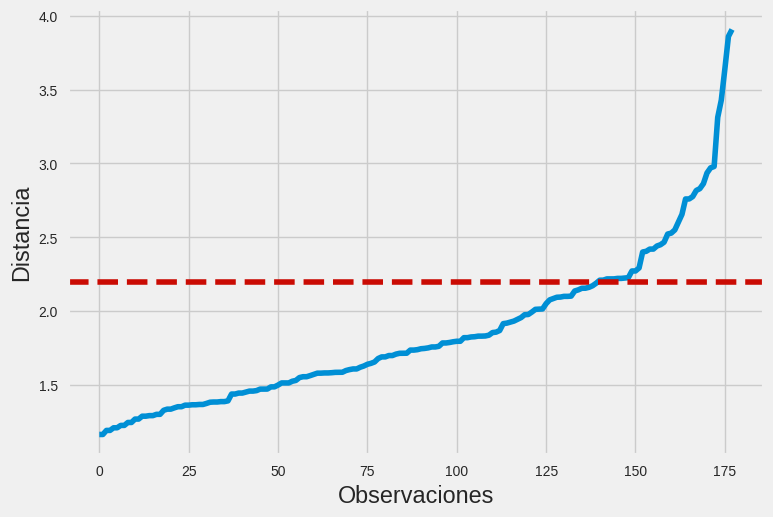

In [ ]:
k = 2
data_nn = wine_f.copy()

# Calculamos los vecinos más cercanos
nearest_neighbors = NearestNeighbors(n_neighbors=k)
neighbors = nearest_neighbors.fit(data_nn)
distances, indices = neighbors.kneighbors(data_nn)
distances = np.sort(distances, axis=0)

# Obtenemos las distancias
distances = distances[:,1]

i = np.arange(len(distances))

sns.lineplot(
    x = i,
    y = distances
)
plt.axhline(y = 2.2, color = 'r', linestyle = '--')
plt.xlabel("Observaciones")
plt.ylabel("Distancia")

In [ ]:
#Realizamos el clustering
dbscan_clusters = DBSCAN(eps = 2.2, min_samples = 5).fit(wine_f)

In [ ]:
#Las observaciones que quedan con un valor de -1 son los puntos ruido (o outliers). Por lo que son las observaciones que no asignó a ningun cluster
dbscan_clusters.labels_

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0,  0,
        0,  0,  0,  0, -1,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0, -1,  0, -1,  0, -1,  0, -1,  0,  0,  0,  0, -1,
        0,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1, -1, -1,  0,  0, -1,  0,
       -1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1,  0,  0,  0,  1, -1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0, -1, -1,  0,  0,
        0,  0,  0, -1,  0,  0,  0, -1, -1,  0, -1,  0,  0, -1,  0,  0, -1,
        0,  0, -1, -1, -1, -1,  0,  0, -1,  0, -1, -1,  1,  1,  1, -1,  1,
       -1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1, -1,
        1, -1,  1,  1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
        1,  1,  1,  1,  1,  1, -1,  1])

In [ ]:
#Y también sumamos a DBScan a nuestra tablita...
finalDf['dbscan'] = pd.Series(dbscan_clusters.labels_)

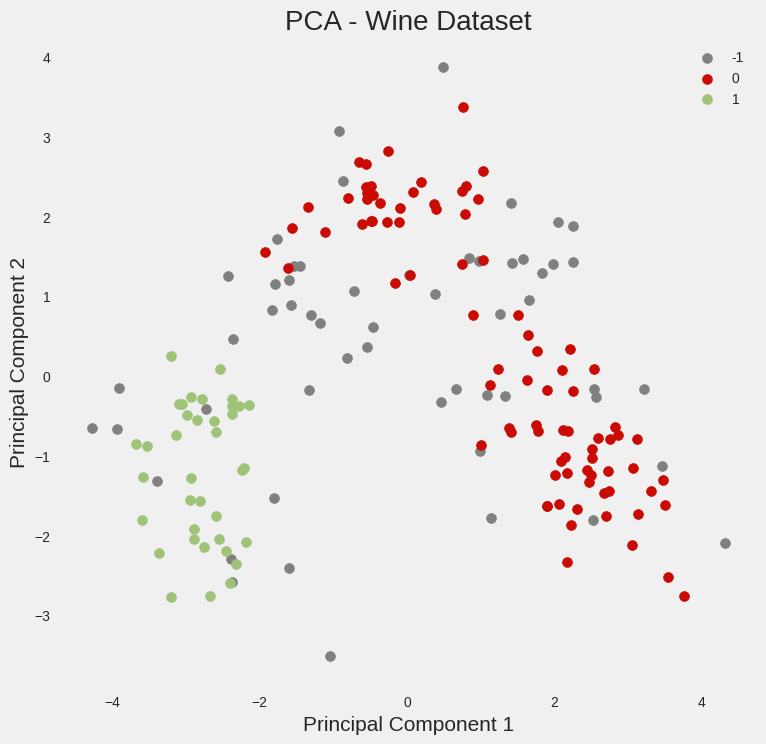

In [ ]:
#Veamos que tal le fue
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA - Wine Dataset', fontsize = 20)
targets = [-1, 0, 1]
colors = ['gray', 'r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['dbscan'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
finalDf

,principal component 1,principal component 2,class,hclust,kmeans,dbscan,dbscan_pca
0,3.316751,-1.443463,1,2,1,0,0
1,2.209465,0.333393,1,2,1,0,0
2,2.516740,-1.031151,1,2,1,0,0
3,3.757066,-2.756372,1,2,1,0,-1
4,1.008908,-0.869831,1,2,1,0,0
...,...,...,...,...,...,...,...
173,-3.370524,-2.216289,3,1,2,1,1
174,-2.601956,-1.757229,3,1,2,1,1
175,-2.677839,-2.760899,3,1,2,1,1
176,-2.387017,-2.297347,3,1,2,-1,1


¡Horrible!

**NOTA:** Los métodos de clustering que se basan en densidad de puntos no dan buenos resultados en espacios de alta dimensionalidad (nuestros datos viven en un espacio de 13 dimensiones). Por lo que antes de aplicarse esta clase de métodos, se suele utilizar una reducción de dimensionalidad como PCA. **¿Se acuerdan de la maldición de la dimensionalidad?**

In [ ]:
#Vamos a volver a calcular DBSCAN pero sobre la reduccion de dimensionalidad que habíamos hecho (ahora no la estamos usando sólo para visualizarlo datos, no?)
pca_data = finalDf.loc[:,['principal component 1',	'principal component 2']]

Text(0, 0.5, 'Distance')

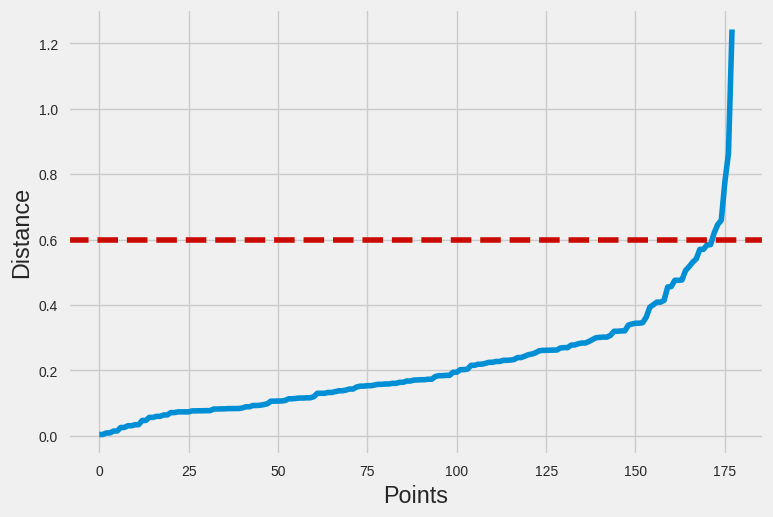

In [ ]:
#Volvemos a ver qué valor de Eps nos puede servir
k = 2
data_nn = pca_data.copy()

# Calculamos los vecinos más cercanos
nearest_neighbors = NearestNeighbors(n_neighbors=k)
neighbors = nearest_neighbors.fit(data_nn)
distances, indices = neighbors.kneighbors(data_nn)
distances = np.sort(distances, axis=0)

# Obtenemos las distancias
distances = distances[:,1]

i = np.arange(len(distances))

sns.lineplot(
    x = i,
    y = distances
)
plt.axhline(y = 0.6, color = 'r', linestyle = '--')
plt.xlabel("Points")
plt.ylabel("Distance")

In [ ]:
#DBSCAN
dbscan_clusters = DBSCAN(eps = 0.6, min_samples = 5).fit(pca_data)

In [ ]:
dbscan_clusters.labels_

array([ 0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,
        0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0, -1,  0,  0,  0,  0, -1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  1,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,
        0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1, -1,
        1,  1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1])

In [ ]:
finalDf['dbscan_pca'] = pd.Series(dbscan_clusters.labels_)

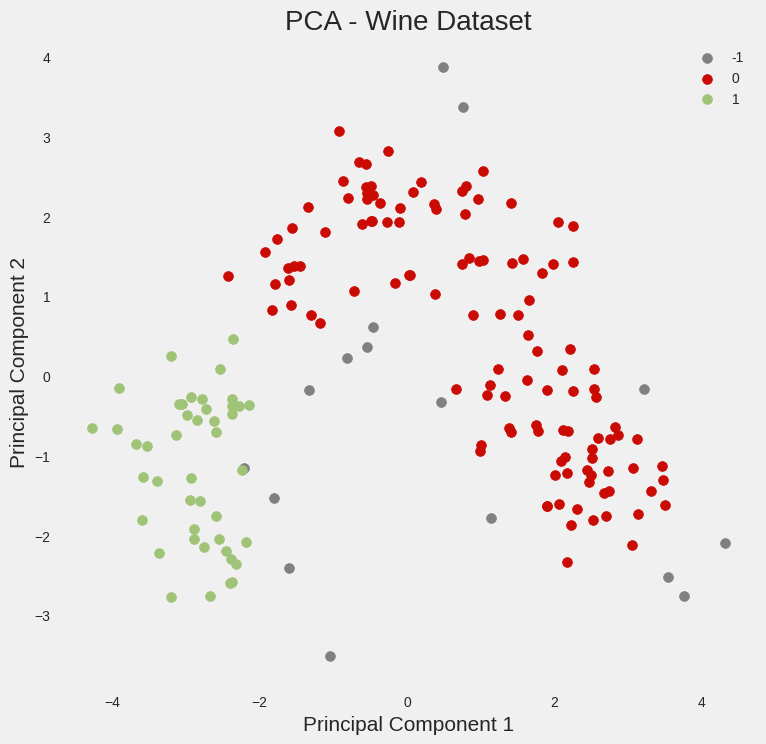

In [ ]:
#plotting the data
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA - Wine Dataset', fontsize = 20)
targets = [-1, 0, 1]
colors = ['gray', 'r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['dbscan_pca'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

¡Un poco mejor! Noten que hay una menor cantidad de outliers

### Evaluación de los distintos métodos de clustering
Vamos a comparar solo el clustering jerarquico y kmeans, porque vimos que DBSCAN viene con desventaja.

Teníamos dos tipos de validaciones...

#### Validación Externa
Pongamos en acción las etiquetas que teníamos...

[Indice de Rand Ajustado (ARI)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)

In [ ]:
#Para el clustering jerarquico
labels_true = wine_class
labels_pred = finalDf['hclust']

adjusted_rand_score(labels_true, labels_pred)

0.7899332213582837

In [ ]:
#Para kmeans
labels_true = wine_class
labels_pred = finalDf['kmeans']

adjusted_rand_score(labels_true, labels_pred)

0.8974949815093207

#### Validación Interna

[Davies-Bouldin Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.davies_bouldin_score.html)

In [ ]:
#Clustering Jerarquico
davies_bouldin_score(wine_f, finalDf['hclust'])

1.4185919431857326

In [ ]:
#Kmeans
davies_bouldin_score(wine_f, finalDf['kmeans'])

1.3891879777181648

[Silhoutte Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)

In [ ]:
#Clustering Jerarquico
silhouette_score(wine_f, finalDf['hclust'])

0.2774439826952265

In [ ]:
#Kmeans
silhouette_score(wine_f, finalDf['kmeans'])

0.2848589191898987

Para realizar los gráficos de Silhouette vamos a usar una librería llamada [Yellowbrick](https://www.scikit-yb.org/en/latest/) que agrega varias herramientas gráficas para problemas de machine learning. Con esta función solo vamos a poder graficar el modelo de KMeans porque *AgglomerativeClustering()* no tiene el método *predict*. Asi que aprovechemos a comparar dos KMeans con distintos valores para k. ¿Elegimos bien? ¿Qué les parece?

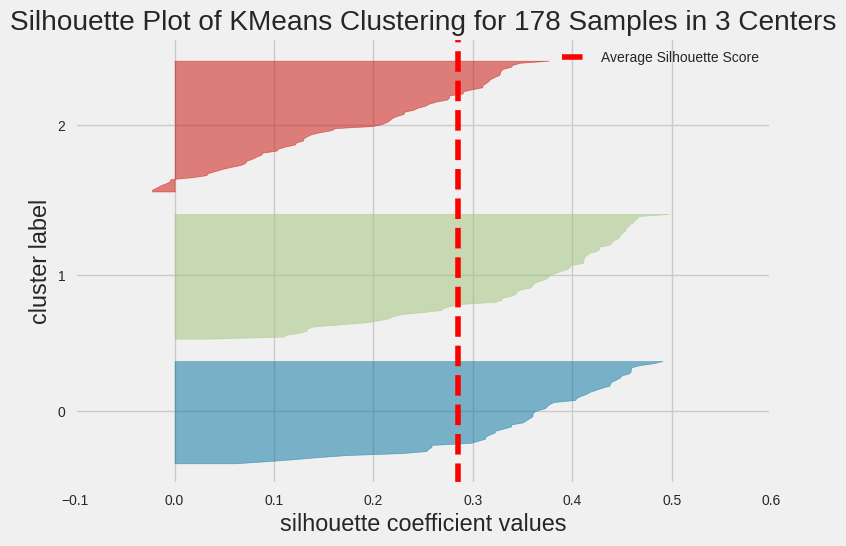

SilhouetteVisualizer(ax=<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 178 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=3, n_init=10, random_state=42))

In [ ]:
#Kmeans con k=3 (el que elegimos)
silhouette_visualizer(KMeans(3, n_init=10, random_state=42), wine_f, colors='yellowbrick')

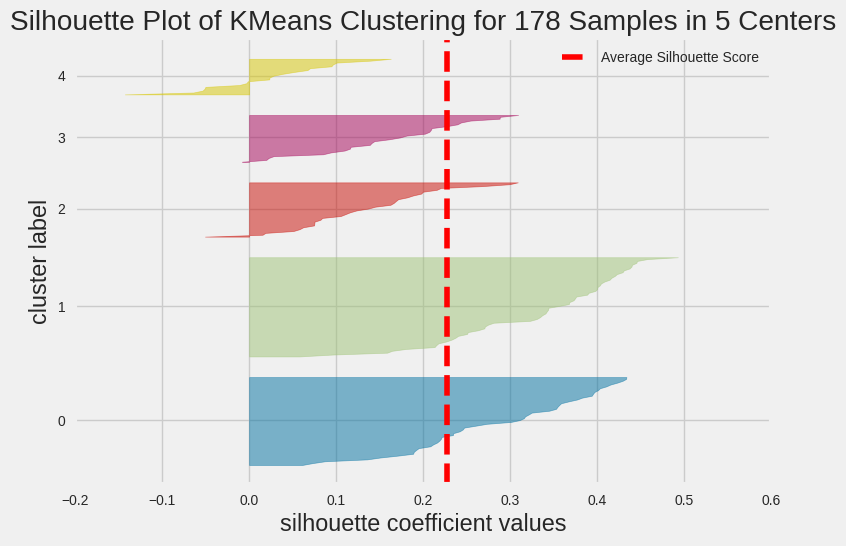

SilhouetteVisualizer(ax=<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 178 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=5, n_init=10, random_state=42))

In [ ]:
#Kmeans con k=5
silhouette_visualizer(KMeans(5, n_init=10, random_state=42), wine_f, colors='yellowbrick')